# Selecting Logistic Regression Model with K-Fold CV

In the attached workspace, you will use K-fold CV to select the regularization strength in an L1-regularized classification model. Then, you will fit the optimal model and evaluate it on a test set not used for model fitting.

Name | Type	| Description
| ---- | ---- | ---- |
|`score_mean`	| 1d numpy array  |	The mean validation score for each model | in the K-fold CV.|
|`C_best`	|float	|The value of the tuning parameter C that yields the best score on the validation data.|
|`yhat_ts`	|1d numpy array	|1d numpy array containing the predictions of the best model for the test set.|
|`score_ts`	|float|	The score of the optimal model on the test set.|

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold

You are hired by a major social media platform to develop a machine learning model that will be used to clearly mark *satirical news
articles* when they are shared on social media. 

To train your model, you are using a dataset of 9,000 headlines from [The Onion](https://www.theonion.com/) and 15,000 headlines scraped from [Not The Onion on Reddit](https://www.reddit.com/r/nottheonion/).

First, load in the data:

In [2]:
df = pd.read_csv("OnionOrNot.csv")

The data frame includes

*  a `text` field, which has the text of the headline, 
* and a `label` field indicating if it is from The Onion (1) or not (0).


In [3]:
df.head()

,text,label
0,Entire Facebook Staff Laughs As Man Tightens P...,1
1,Muslim Woman Denied Soda Can for Fear She Coul...,0
2,Bold Move: Hulu Has Announced That They’re Gon...,1
3,Despondent Jeff Bezos Realizes He’ll Have To W...,1
4,"For men looking for great single women, online...",1


Because the data is scraped from Reddit, it's not very clean - some of the entries in `text` are not exactly a headline, and some include a subheading like "The Onion - America's Finest News Source" or equivalent (this is an example of data leakage! The target variable is "leaked" into the feature data.)

For example:

In [4]:
df.iloc[26].text

"The Onion Reviews 'Avengers: Age Of Ultron'"

As a very basic cleaning step to address this, we will drop every row that has the word `onion` or `Onion` in it:

In [5]:
df = df[~df.text.str.contains('nion')]

To train a model, we will need to get this text into some kind of numeric representation. We will use a basic approach called "bag of words", that works as follows:

0. (Optional) Remove the "trivial" words that you want to ignore, such as "the", "an", "has", etc. from the text.
1. Compile a "vocabulary" - a list of all of the words in the dataset - with integer indices from 0 to $d-1$.
2. Convert every sample into a $d$-dimensional vector $x$, by letting the $j$th coordinate of $x$ be the number of occurences of the $j$th words in the document. (This number is often called the "term frequency".)

Now, we have a set of vectors - one for each sample - containing the frequency of each word.

For example, if we had two samples:

```
dog eats dog
dog eats cat
```

our "vocabulary" might be

```
dog,0
eats,1
cat,2
```

and the two samples would be represented by the term frequencies

```
2,1,0
1,1,1
```

There are more sophisticated ways of representing text, but this approach will work for now. We will use the `sklearn` implementation of this, which is called `CountVectorizer`. 

First, we will split the data into training and test sets:

In [6]:
Xtr_str, Xts_str, ytr, yts = train_test_split(df['text'].values, df['label'].values, shuffle=True, random_state=42, test_size=0.3)

Then, we'll create an instance of a `CountVectorizer`, specify the list of "stop words" to remove, and "fit" it using the text from the training set:

In [7]:
vec = CountVectorizer(stop_words='english')
Xtr_vec = vec.fit_transform(Xtr_str)
Xts_vec = vec.transform(Xts_str)

Now we have Xtr_vec and Xts_vec, the text of the headlines, in the form of a numeric array that we can use to train a LogisticRegression classifier. (Note that these arrays have a very large number of columns - one for every word in the vocabular! - so they are represented internally as a "sparse" matrix.)

In [8]:
Xtr_vec.shape

(16485, 20635)

In [9]:
Xts_vec.shape

(7066, 20635)

(Optional: If you are interested, you can run

```
vec.vocabulary_
```

to see the "vocabulary".)

**Note**: when using a regularized model, we standardize the data if features do not share a common scale. In this case, all features are on the same scale (frequency) so we do *not* standardize.

Since many of the words will not be so relevant for predicting whether or not a headline is satirical, we can use L1 regularization to "de-select" some features.

In an `sklearn` `LogisticRegression`, the hyperparameter `C` controls the "strength" of the regularization term in the objective function. `C` is the **inverse** of the regularization strength; a greater value of `C` means the model is *less* regularized.

We will evaluate models for the following values of `C`:

In [10]:
C_test = np.logspace(-1,3,20)

In the following cells, we are going to set up a K-fold CV to select a value of `C`.  First, we will set up an array to hold the results of each model in each fold. (Note that our K-fold CV will use 5 folds.)

In [11]:
nfold = 5
score_val = np.zeros((len(C_test), nfold))

Now, create a KFold object using the `sklearn` implementation.

* Use 5 folds (and don't shuffle the data inside the K-Fold CV). 

Use this to evalute an `sklearn` `LogisticRegression` regression model for each of the `C` values in `C_test`, and save the validation score inside `score_val`. In the `LogisticRegression`, 

* specify `solver = 'liblinear'`
* specify `penalty = 'l1'`
* specify `random_state = 42`

and leave other hyperparameters and settings at their default values, expect for `C`.

Also, we will use the F1 score (`f1_score` in `sklearn`) for model selection - i.e. we will select the model with the best validation F1 score, so:

* inside your KFold, evaluate the `f1_score` and save the scores in `score_val`


In [12]:
#grade (write your code in this cell and DO NOT DELETE THIS LINE)

kf = KFold(n_splits=nfold, shuffle=False)

# For each fold
for ifold, (Itr, Ival) in enumerate(kf.split(Xtr_vec)):
    # For each C in the list, fit a LogisticRegression model
    for iC, C in enumerate(C_test):
        clf  = LogisticRegression(random_state = 42, solver = 'liblinear', penalty='l1', C = C)
        clf.fit(Xtr_vec[Itr], ytr[Itr])
        yhat = clf.predict(Xtr_vec[Ival])
        # update the appropriate entry in score_val
        score_val[iC, ifold] = f1_score(ytr[Ival], yhat)

Next, compute the mean validation score for each of the models, and identify the value of `C` with the best validation score.

In [13]:
#grade (write your code in this cell and DO NOT DELETE THIS LINE)
score_mean = np.mean(score_val, axis=1)
C_best = C_test[np.argmax(score_mean)]

Use this visualization to review your work!

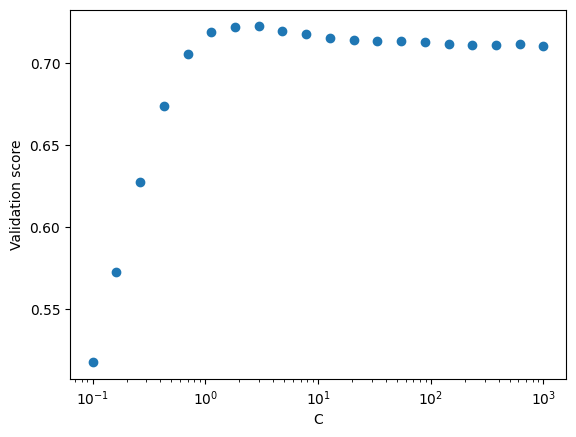

In [14]:
#grade (write your code in this cell and DO NOT DELETE THIS LINE)
import matplotlib.pyplot as plt
plt.scatter(C_test, score_mean);
plt.xscale('log');
plt.xlabel('C');
plt.ylabel("Validation score");

Using the `C` value you identified in the previous step (and the rest of the logistic regression parameters as specified earlier), fit a logistic regression model on the entire training set. Then, get its prediction on the test set in `y_hat`, and compute the score of the F1 score model on the test set.

In [15]:
#grade (write your code in this cell and DO NOT DELETE THIS LINE)
clf_best  = LogisticRegression(random_state = 42, solver = 'liblinear', penalty='l1', C = C_best)
clf_best.fit(Xtr_vec, ytr)
yhat_ts = clf_best.predict(Xts_vec)
score_ts = f1_score(yts, yhat_ts)